### Installing the necessary packages

In [31]:
!pip install --quiet tensorflow==2.7.0

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-quantum 0.7.2 requires cirq-core==0.13.1, but you have cirq-core 1.0.0 which is incompatible.
tensorflow-quantum 0.7.2 requires protobuf==3.17.3, but you have protobuf 3.19.6 which is incompatible.


In [32]:
!pip install --quiet tensorflow-quantum==0.7.2

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
proto-plus 1.22.1 requires protobuf<5.0.0dev,>=3.19.0, but you have protobuf 3.17.3 which is incompatible.
cirq 1.0.0 requires cirq-core==1.0.0, but you have cirq-core 0.13.1 which is incompatible.
cirq 1.0.0 requires cirq-google==1.0.0, but you have cirq-google 0.13.1 which is incompatible.
cirq-web 1.0.0 requires cirq-core==1.0.0, but you have cirq-core 0.13.1 which is incompatible.
cirq-rigetti 1.0.0 requires cirq-core==1.0.0, but you have cirq-core 0.13.1 which is incompatible.
cirq-pasqal 1.0.0 requires cirq-core==1.0.0, but you have cirq-core 0.13.1 which is incompatible.
cirq-ionq 1.0.0 requires cirq-core==1.0.0, but you have cirq-core 0.13.1 which is incompatible.
cirq-aqt 1.0.0 requires cirq-core==1.0.0, but you have cirq-core 0.13.1 which is incompatible.


In [33]:
!pip install --quiet cirq

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-quantum 0.7.2 requires cirq-core==0.13.1, but you have cirq-core 1.0.0 which is incompatible.
tensorflow-quantum 0.7.2 requires protobuf==3.17.3, but you have protobuf 3.20.3 which is incompatible.
tensorboard 2.10.1 requires protobuf<3.20,>=3.9.2, but you have protobuf 3.20.3 which is incompatible.


### Importing the necessary packages

In [34]:
import tensorflow as tf
import tensorflow_quantum as tfq

import cirq
import sympy
import numpy as np
import seaborn as sns
import collections

# visualization tools
%matplotlib inline
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit

# **Data preprocessing**

In [35]:
# Loading the data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

In [36]:
# Normalizing the data
x_train, x_test = x_train[..., np.newaxis]/255.0, x_test[..., np.newaxis]/255.0

### Function to keep only digit 3 and digit 6

In [37]:
def keep_only_3_and_6(a, b):
    keep = (b == 3) | (b == 6)
    a, b = a[keep], b[keep]
    b = b == 3
    return a,b

In [38]:
x_train, y_train = keep_only_3_and_6(x_train, y_train)
x_test, y_test = keep_only_3_and_6(x_test, y_test)


### Seeing an example

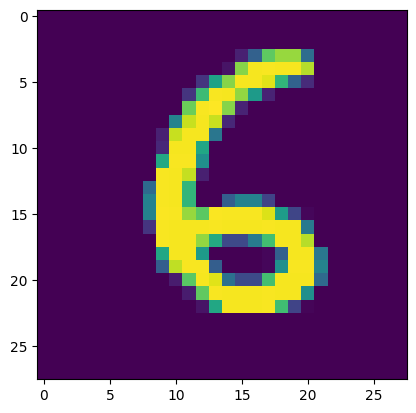

In [39]:
plt.imshow(x_train[25, :, :, 0])

### Function to resize

In [40]:
def resize_to_4_x_4(dataset, size):
    return tf.image.resize(dataset, size).numpy()

In [41]:
x_train_resized = resize_to_4_x_4(x_train, (4,4))
x_test_resized = resize_to_4_x_4(x_test, (4,4))

True


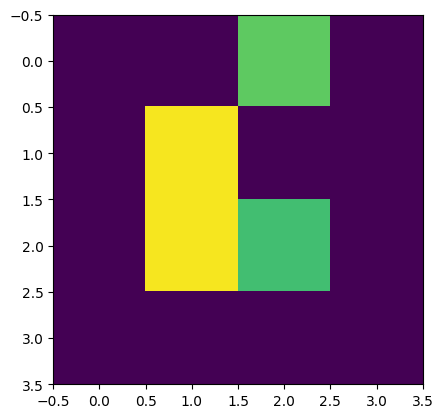

In [42]:
print(y_train[0])

plt.imshow(x_train_resized[25,:,:,0], vmin=0, vmax=1)
plt.savefig('sixx.png')

### Remove conradictory examples

In [43]:
def remove_contradicting_images(xs, ys):

    # In the end "mapping" will hold the number of unique images
    mapping = collections.defaultdict(set)
    orig_x = {}

    # Establish the labels for each individual image.:
    for x,y in zip(xs,ys):
      orig_x[tuple(x.flatten())] = x
      mapping[tuple(x.flatten())].add(y)

    new_x = []
    new_y = []

    for flatten_x in mapping:
      x = orig_x[flatten_x]
      labels = mapping[flatten_x]
      if len(labels) == 1:
          new_x.append(x)
          new_y.append(next(iter(labels)))
      else:
          # Images that match multiple labels are discarded
          pass

    # Number of unique images of digit 3
    unique_images_3 = sum(1 for value in mapping.values() if len(value) == 1 and True in value)

    # Number of unique images of digit 6
    unique_images_6 = sum(1 for value in mapping.values() if len(value) == 1 and False in value)
    return np.array(new_x), np.array(new_y)

In [44]:
x_train_no_contradicting, y_train_no_contradicting = remove_contradicting_images(x_train_resized, y_train)

# **Converting images to quantum circuits**

### Applying threshold

In [45]:
# As this is a binary classifier, thereshold is 0.5
threshold = 0.5

x_train_binary = np.array(x_train_no_contradicting > threshold, dtype=np.float32)
x_test_binary = np.array(x_test_resized > threshold, dtype=np.float32)

In [46]:
def convert_image_to_circuit(image):
    image_values = np.ndarray.flatten(image)
    qubits = cirq.GridQubit.rect(4, 4)
    quantum_circuit = cirq.Circuit()
    for i, value in enumerate(image_values):
        if value:
            quantum_circuit.append(cirq.X(qubits[i]))
    return quantum_circuit


x_train_circuit = [convert_image_to_circuit(x) for x in x_train_binary]
x_test_circuit = [convert_image_to_circuit(x) for x in x_test_binary]

### Training data's quantum circuit

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


Training data:


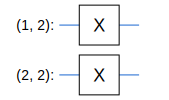

In [47]:
print("Training data:")
SVGCircuit(x_train_circuit[1])

### Testing data's quantum circuit

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


Test data:


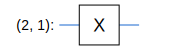

In [48]:
print("Test data:")
SVGCircuit(x_test_circuit[1])

### Convert to tensors

In [49]:
x_train_tensors = tfq.convert_to_tensor(x_train_circuit)
x_test_tensors = tfq.convert_to_tensor(x_test_circuit)

# **Quantum Neural Network Model**

In [50]:
class CircuitLayerBuilder():
    def __init__(self, data_qubits, readout_qubit):
        self.data_qubits = data_qubits
        self.readout_qubit = readout_qubit

    def add_layer(self, circuit, gate, prefix):
        for i, qubit in enumerate(self.data_qubits):
            symbol = sympy.Symbol(prefix + '-' + str(i))
            circuit.append(gate(qubit, self.readout_qubit)**symbol)

### Create a sample circuit

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


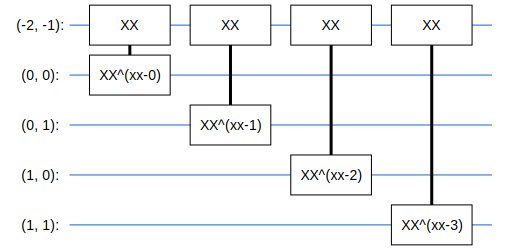

In [51]:
sample_circuit = CircuitLayerBuilder(data_qubits = cirq.GridQubit.rect(2,2),
                                   readout_qubit=cirq.GridQubit(-2,-1))

quantum_circuit = cirq.Circuit()
sample_circuit.add_layer(quantum_circuit, gate = cirq.XX, prefix='xx')
SVGCircuit(quantum_circuit)

### Create circuit for QNN

In [52]:
def create_quantum_model():
    data_qubits = cirq.GridQubit.rect(4, 4)        # a 4x4 grid.
    readout_qubit = cirq.GridQubit(-1, -1)         # a single qubit at [-1,-1]
    quantum_circuit = cirq.Circuit()

    # Preparing the readout qubit.
    quantum_circuit.append(cirq.X(readout_qubit))
    quantum_circuit.append(cirq.H(readout_qubit))

    builder = CircuitLayerBuilder(
        data_qubits = data_qubits,
        readout_qubit=readout_qubit)

    # Adding layers
    builder.add_layer(quantum_circuit, cirq.XX, "xx1")
    builder.add_layer(quantum_circuit, cirq.ZZ, "zz1")

    # Finally, prepare the readout qubit.
    quantum_circuit.append(cirq.H(readout_qubit))

    return quantum_circuit, cirq.Z(readout_qubit)

In [53]:
model_circuit, model_readout = create_quantum_model()

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

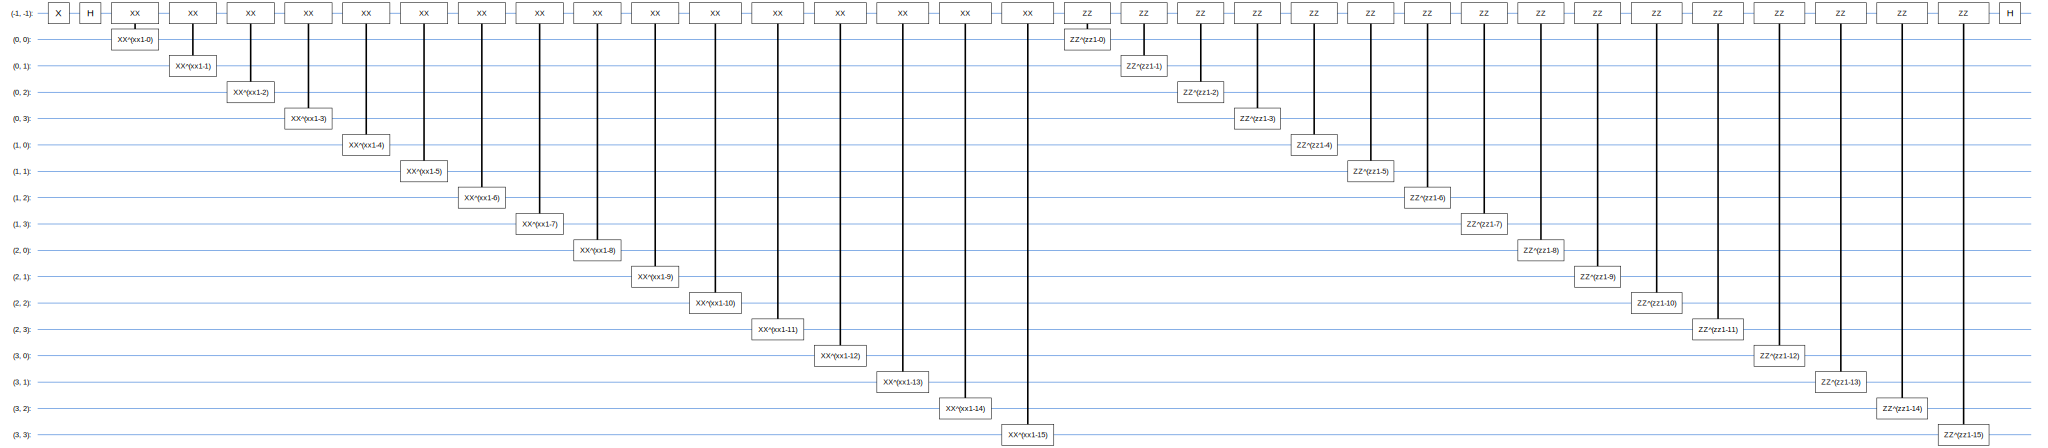

In [54]:
SVGCircuit(model_circuit)

### Build the Keras model

In [55]:
model = tf.keras.Sequential([
    # The input is the data-circuit, encoded as a tf.string
    tf.keras.layers.Input(shape=(), dtype=tf.string),
    tfq.layers.PQC(model_circuit, model_readout),
])

In [56]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 pqc_1 (PQC)                 (None, 1)                 32        
                                                                 
Total params: 32
Trainable params: 32
Non-trainable params: 0
_________________________________________________________________


### Converting from True/False to [-1, 1]

In [57]:
y_train_hinge = 2.0*y_train_no_contradicting-1.0
y_test_hinge = 2.0*y_test-1.0

### Hinge accuracy

In [58]:
def hinge_accuracy(y_true, y_pred):
    y_true = tf.squeeze(y_true) > 0.0
    y_pred = tf.squeeze(y_pred) > 0.0
    result = tf.cast(y_true == y_pred, tf.float32)

    return tf.reduce_mean(result)

### Compiling the model

In [59]:
model.compile(
    loss=tf.keras.losses.Hinge(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=[hinge_accuracy])

# **Training the model**

In [60]:
qnn_history = model.fit(
      x_train_tensors, y_train_hinge,
      batch_size=32,
      epochs=10,
      verbose=1,
      validation_data=(x_test_tensors, y_test_hinge))

Epoch 1/10
324/324 [==============================] - 32s 99ms/step - loss: 0.6823 - hinge_accuracy: 0.7366 - val_loss: 0.4548 - val_hinge_accuracy: 0.8075
Epoch 2/10
324/324 [==============================] - 32s 98ms/step - loss: 0.3857 - hinge_accuracy: 0.8507 - val_loss: 0.3535 - val_hinge_accuracy: 0.9103
Epoch 3/10
324/324 [==============================] - 32s 99ms/step - loss: 0.3516 - hinge_accuracy: 0.8939 - val_loss: 0.3424 - val_hinge_accuracy: 0.9078
Epoch 4/10
324/324 [==============================] - 32s 98ms/step - loss: 0.3467 - hinge_accuracy: 0.8933 - val_loss: 0.3321 - val_hinge_accuracy: 0.8730
Epoch 5/10
324/324 [==============================] - 32s 98ms/step - loss: 0.3440 - hinge_accuracy: 0.8910 - val_loss: 0.3361 - val_hinge_accuracy: 0.9073
Epoch 6/10
324/324 [==============================] - 32s 99ms/step - loss: 0.3437 - hinge_accuracy: 0.8912 - val_loss: 0.3369 - val_hinge_accuracy: 0.9073
Epoch 7/10
324/324 [==============================] - 32s 100ms/

### Evaluating the model

In [61]:
qnn_results = model.evaluate(x_test_tensors, y_test)

print(qnn_results)

62/62 [==============================] - 2s 31ms/step - loss: 0.3411 - hinge_accuracy: 0.9088
[0.34108731150627136, 0.9087701439857483]


### Accuracy

In [62]:
accuracy = qnn_results[1] * 100
print("The accuracy of the model is: ", str(accuracy) + ' %')

The accuracy of the model is:  90.87701439857483 %


# **Inference on an encrypted image**

### Importing the necessary packages

In [63]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from cryptography.fernet import Fernet
import time
import cv2

### Constructing necessary functions

In [64]:
# Function to display image
def show_image(image):
    img = mpimg.imread(image)
    print('Shape of the image is: ', img.shape)
    plt.axis('off')
    imgplot = plt.imshow(img)
    plt.show()


# Function to encrypt an image
def encrypt(image):
    key = Fernet.generate_key()
    with open('mykey.key', 'wb') as mykey:
        mykey.write(key)
    with open('mykey.key', 'rb') as mykey:
        key = mykey.read()
    print("Your secret key is: ", key)
    f = Fernet(key)
    with open(image, 'rb') as original_file:
        original = original_file.read()
    print("\nEncrypting the image with the secret key....")
    time.sleep(5)
    print("\nEncryption successful!")
    encrypted = f.encrypt(original)
    with open ('encrypted_image.png', 'wb') as encrypted_file:
        encrypted_file.write(encrypted)

        
# Function to decrypt an image
def decrypt(enc_img, key):
    f = Fernet(key)
    with open('encrypted_image.png', 'rb') as encrypted_file:
        encrypted = encrypted_file.read()
    print("Decrypting the given image....")
    time.sleep(5)
    decrypted = f.decrypt(encrypted)
    with open('decrypted_image.png', 'wb') as decrypted_file:
        decrypted_file.write(decrypted)
    print("\nDecryption successful!")


# Function to process an image and perform the prediction
def image_processing_and_prediction(image):
    img = image[..., np.newaxis]/255.0
    img = tf.image.resize(img, (4,4)).numpy()
    # print("Shape of the image is: ",img.shape)
    threshold = 0.5
    img = np.array(img > threshold, dtype=np.float32)
    img_circ = [convert_image_to_circuit(img)]
    processed_img = tfq.convert_to_tensor(img_circ)

    # Prediction
    prediction = model.predict(processed_img)
    # print('Prediction is: ', prediction)
    if prediction[0][0] < 0:
        print("The image is of digit 3")
    else:
        print("The image is of digit 6")

### Sample Image

Shape of the image is:  (288, 432, 4)


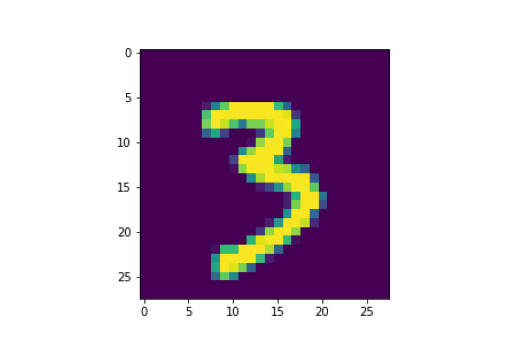

In [65]:
digit_img = './three.png'
show_image(digit_img)

### Encrypting the image

In [66]:
encrypt(digit_img)

Your secret key is:  b'p2GIaYjIfNDBKWCax8ZMyhHFPB6FYaeVR0_toiwmSGY='

Encrypting the image with the secret key....

Encryption successful!


### Checking whether the key and encrypted image is generated

In [73]:
!ls

decrypted_image.png  encrypted_image.png  mykey.key  qnn_mnist.ipynb  three.png


### Decrypting the image

In [68]:
with open('./mykey.key', mode='rb') as file:
    secret_key = file.read()

enc_img = './encrypted_image.png'
decrypt(enc_img, secret_key)

Decrypting the given image....

Decryption successful!


### Checking whether the decrypted image is generated

In [72]:
!ls

decrypted_image.png  encrypted_image.png  mykey.key  qnn_mnist.ipynb  three.png


### Seeing the decrypted image

Shape of the image is:  (288, 432, 4)


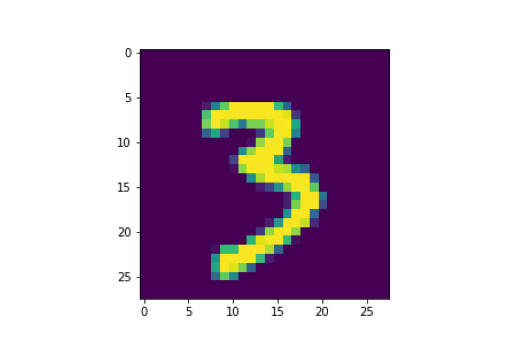

In [74]:
show_image('./decrypted_image.png')

### Loading the decrypted image and performing preprocessing

In [75]:
# Load decrypted image
file = r'./decrypted_image.png'
test_image = cv2.imread(file, cv2.IMREAD_GRAYSCALE)
before_resizing = test_image.shape

# Resizing the image to make it suitable for prediction
img_resized = cv2.resize(test_image, (28, 28), interpolation=cv2.INTER_LINEAR)
img_resized = cv2.bitwise_not(img_resized)
after_resizing = img_resized.shape

print("The size of the image has been resized from " + str(before_resizing) + " to " + str(after_resizing))

The size of the image has been resized from (288, 432) to (28, 28)


### Inference (prediction)

In [76]:
image_processing_and_prediction(img_resized)

The image is of digit 3
